# Статистические тесты для исторических данных

In [129]:
from alex.database import Database # вспомогательный класс для подключения к базе и работе с sql
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from decimal import Decimal
%matplotlib inline
from pprint import pprint

In [130]:
# stat packages
from statsmodels.tsa.stattools import acf # функция расчёта автокорреляций
from statsmodels.graphics.tsaplots import plot_acf # визуализация автокорреляций
from statsmodels.tsa.stattools import adfuller # Расширенный тест Дики-Фуллера

In [131]:
import altair as alt # пакет визуализации Altair
alt.renderers.enable('notebook')
alt.data_transformers.enable('csv')

DataTransformerRegistry.enable('csv')

In [132]:
db = Database() # подключение к базе данных с учётными данными для Alex

## Загрузка истории

In [318]:
exchange = "binance"
pair = "ETH/USDT"
lag_seconds = 57600 # 86400 - 1 day

sql = f"select * from tvf_get_history_seconds_ago({lag_seconds}) order by dt, id"
history = db.query(sql)
# history = db.optimize_df(db.query(sql))

In [319]:
history.index = pd.to_datetime(history['dt'])
del history['dt']
history['volume'] = history.price * history.amount

In [320]:
history.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 235095 entries, 2018-09-30 22:33:50 to 2018-10-01 14:33:47
Data columns (total 8 columns):
id            234821 non-null float64
id_ex_pair    235095 non-null int64
exchange      235095 non-null object
pair          235095 non-null object
price         235095 non-null float64
amount        235095 non-null float64
side          235095 non-null object
volume        235095 non-null float64
dtypes: float64(4), int64(1), object(3)
memory usage: 21.1+ MB


### Фильтрация исходного набора

In [350]:
#history_bak = history.copy()
#history = history[:int(len(history)/4)]
history = history_bak.copy()

## Визуализация загруженных данных

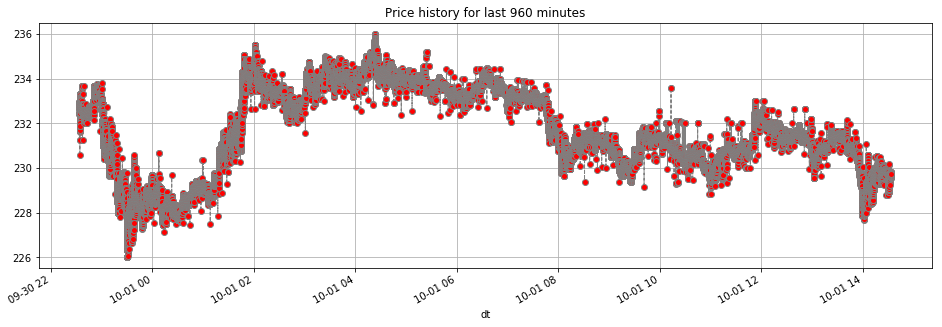

In [351]:
plt.rcParams['figure.figsize'] = [16, 5]
history['price'].plot(grid=True, marker='o', color='gray', linestyle='--', linewidth=1, markerfacecolor='r')
plt.title(f"Price history for last {int(lag_seconds/60)} minutes")
plt.show()

## Мин, макс, среднее, медиана, стд.отклонение

In [352]:
h = history.describe()
mean = h.loc['mean', 'volume']
std = h.loc['std', 'volume']
median = h.loc['50%', 'volume']
low = h.loc['min', 'volume']
high= h.loc['max', 'volume']
print(f"среднее объёма = ${mean:.2f}\n"
      f"медиана объёма = ${median:.2f}\n"
      f"стандартное отклонение объёма = {std:.2f}\n"
      f"минимум объёма = ${low:.6f}\n"
      f"максимум объёма = ${high:.2f}")

среднее объёма = $453.43
медиана объёма = $65.37
стандартное отклонение объёма = 2010.73
минимум объёма = $0.000002
максимум объёма = $296676.38


In [353]:
h = history.describe()
mean = h.loc['mean', 'price']
std = h.loc['std', 'price']
median = h.loc['50%', 'price']
low = h.loc['min', 'price']
high= h.loc['max', 'price']
print(f"среднее цены = ${mean:.2f}\n"
      f"медиана цены = ${median:.2f}\n"
      f"стандартное отклонение цены = {std:.2f}\n"
      f"минимум цены = ${low:.6f}\n"
      f"максимум цены = ${high:.2f}")

среднее цены = $231.24
медиана цены = $231.10
стандартное отклонение цены = 2.00
минимум цены = $226.035400
максимум цены = $236.00


In [354]:
def plot_price(x):
    plt.rcParams['figure.figsize'] = [16, 3]
    plt.plot(x[:100], marker='o', color='gray', linestyle='--', linewidth=1, markerfacecolor='r')
    plt.show()

## Автокорреляции для абсолютных значений цен

In [355]:
print(acf(history.price))

[1.         0.9981757  0.99745203 0.99706581 0.99681738 0.99666362
 0.99653318 0.99641788 0.9963283  0.99626838 0.99620146 0.99614532
 0.99609218 0.99604251 0.9959991  0.99596928 0.99592502 0.99588436
 0.99584616 0.99581163 0.99577822 0.99573161 0.99569452 0.99565828
 0.99560983 0.99557143 0.9955375  0.995497   0.99546774 0.9954194
 0.99537625 0.995341   0.99529052 0.99524997 0.99521133 0.995165
 0.99512103 0.99507972 0.99504648 0.99502131 0.99496787]


Справочно: очень высокая автокорреляция соседних абсолютных значений цены

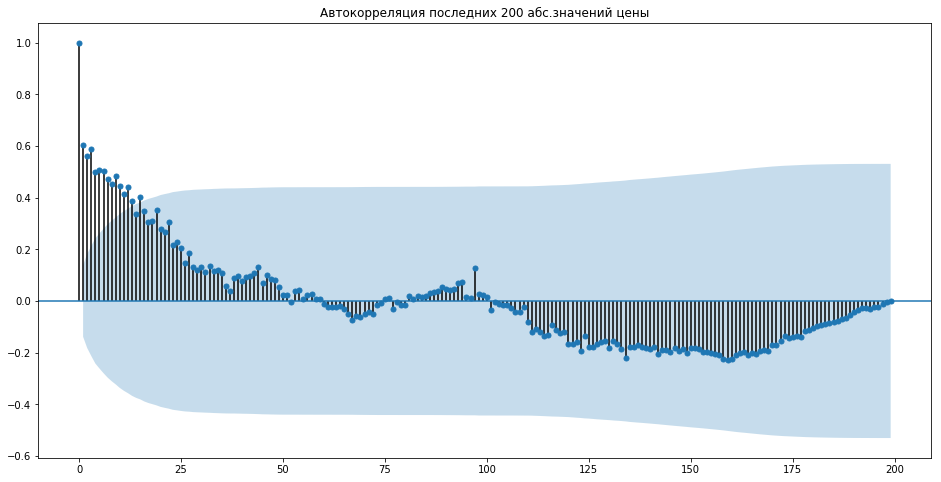

In [356]:
plt.rcParams['figure.figsize'] = [16, 8]
_ = plot_acf(history.price[-200:], title="Автокорреляция последних 200 абс.значений цены", alpha=0.05)

<b>Доверительный интервал</b> в 95% [1 - alpha] обозначен голубым конусом. Значения корреляций ВНЕ этого конуса показывают, что это не просто статистический выброс.<br/><br/>
Корелограмма медленно убывает по синусоиде, что косвенно указывает на нестационарность ряда

### Сравнение со случайной выборкой с теми же параметрами

In [290]:
# генерация белого шума с теми же параметрами, что и цены из history
noise = np.random.normal(loc=history.price.mean(), scale=history.price.std(), size=len(history))

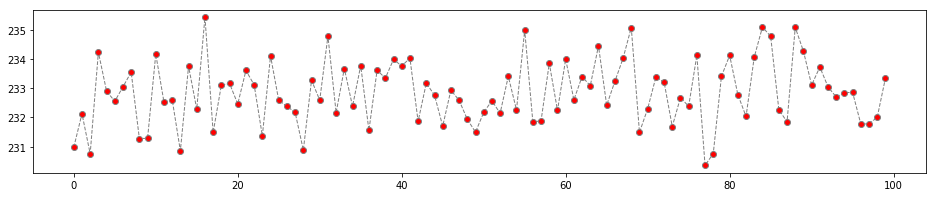

In [291]:
plot_price(noise[-300:])

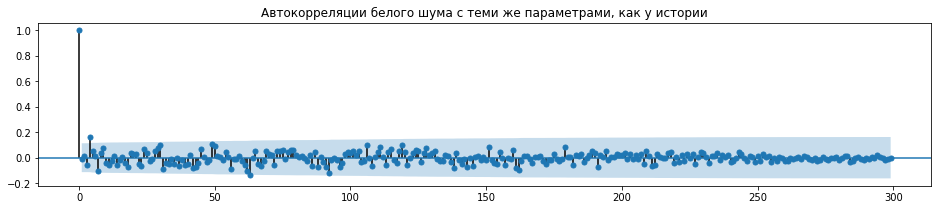

In [292]:
plt.rcParams['figure.figsize'] = [16, 3]
_ = plot_acf(noise[-300:], title="Автокорреляции белого шума с теми же параметрами, как у истории", alpha=0.05)

In [293]:
autocorrelation = pd.Series(noise).autocorr(lag=4)
confidence = 1.96 / np.sqrt(len(noise))
print(f"Автокорреляция  = {autocorrelation*100:.2f}%")
print(f"Приблизительный доверительный интервал = +/- {confidence:.4f}")

Автокорреляция  = -0.60%
Приблизительный доверительный интервал = +/- 0.0277


### Сравнение с синусом

In [294]:
# генерация синуса
Fs = 44100 # sampling rate
f = 1000 # frequency
x = np.arange(len(history)) 
sine = np.sin(2*np.pi * x * f / Fs ) + history.price.mean()

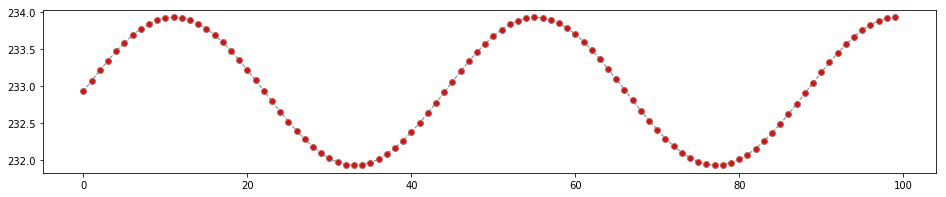

In [295]:
plot_price(sine[:200])

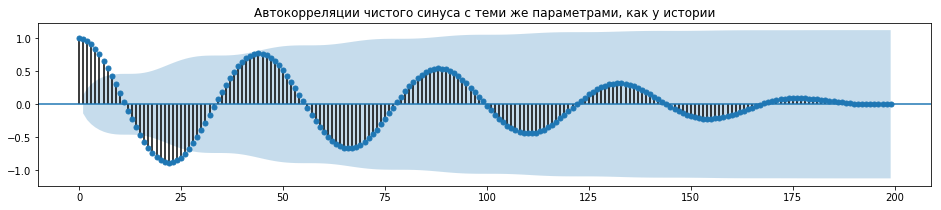

In [296]:
plt.rcParams['figure.figsize'] = [16, 3]
_ = plot_acf(sine[:200], title="Автокорреляции чистого синуса с теми же параметрами, как у истории", alpha=0.05)

In [297]:
autocorrelation = pd.Series(sine).autocorr(lag=4)
confidence = 1.96 / np.sqrt(len(sine))
print(f"Автокорреляция  = {autocorrelation*100:.2f}%")
print(f"Приблизительный доверительный интервал = +/- {confidence:.4f}")

Автокорреляция  = 84.22%
Приблизительный доверительный интервал = +/- 0.0277


## Сравнение с линейным трендом

In [298]:
# генерация тренда
addition = 30 # растём до 30 баксов
trend = np.linspace(start=history.price.mean(), stop=history.price.mean() + addition, num=len(history))

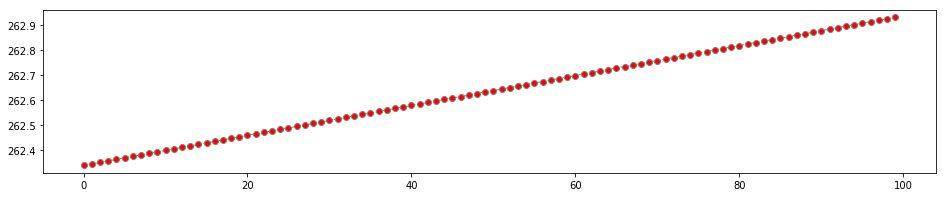

In [299]:
plot_price(trend[-100:])

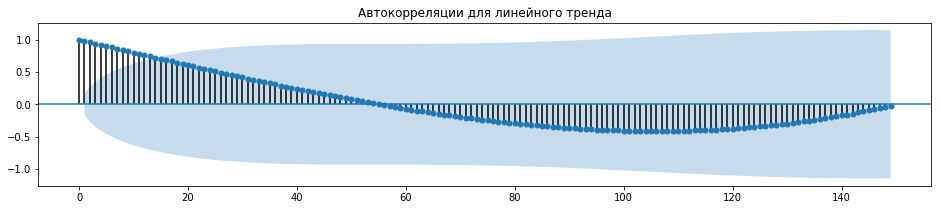

In [300]:
plt.rcParams['figure.figsize'] = [16, 3]
_ = plot_acf(trend[-150:], title="Автокорреляции для линейного тренда", alpha=0.05)

## Конвертация в OHLC

In [357]:
interval = '3min'
df = history[['price', 'amount']].resample(interval).ohlc()

In [358]:
df.shape

(321, 8)

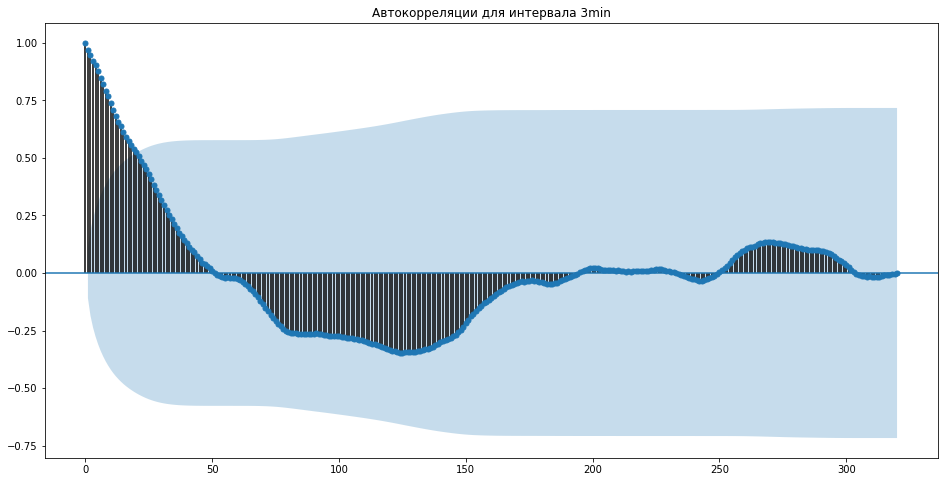

In [359]:
plt.rcParams['figure.figsize'] = [16, 8]
_ = plot_acf(df.price.close, alpha=0.05, title=f"Автокорреляции для интервала {interval}")

In [360]:
autocorrelation = df.price.close.autocorr(lag=1)
confidence = 1.96 / np.sqrt(len(df))
print(f"Автокорреляция по 5-минутным интервалам = {autocorrelation*100:.2f}%")
print(f"Приблизительный доверительный интервал = +/- {confidence:.4f}")

Автокорреляция по 5-минутным интервалам = 97.17%
Приблизительный доверительный интервал = +/- 0.1094


In [378]:
autocorrelation = df.price.close.pct_change().autocorr()
confidence = 1.96 / np.sqrt(len(df))
print(f"Автокорреляция по 5-минутным интервалам изменения по 3-мин интервалу = {autocorrelation*100:.2f}%")
print(f"Приблизительный доверительный интервал = +/- {confidence:.4f}")

Автокорреляция по 5-минутным интервалам изменения по 3-мин интервалу = -13.60%
Приблизительный доверительный интервал = +/- 0.1094


## Тест Dickey-Fuller на стационарность

In [380]:
results = adfuller(history.price)
print(f"p-значение для абсолютных цен равно {results[1]*100:.2f}%")

p-значение для абсолютных цен равно 22.24%


Больше, чем выбранная значимость в 5%. Это ничего не значит, т.к. временной ряд с ценами не является стационарным. <br/><br/>Если ряд стационарен и p-значение меньше 5%, то тогда мы можем отбросить нулевую гипотезу, что временной ряд является случайным блужданием, и тогда существует стат.возможность для прогнозирования.

In [381]:
results = adfuller(df.pct_change().dropna().price.close)
print(f"p-значение для относительных цен равно {results[1]*100:.5f}%")

p-значение для относительных цен равно 0.00000%


Не случайное блуждание.

In [382]:
pprint(results)

(-6.534959138350659,
 9.66019741305452e-09,
 7,
 312,
 {'1%': -3.4514843502727306,
  '10%': -2.571729625657462,
  '5%': -2.8708485956333556},
 -3017.5561077289285)


## Сезонность (разные лаги)

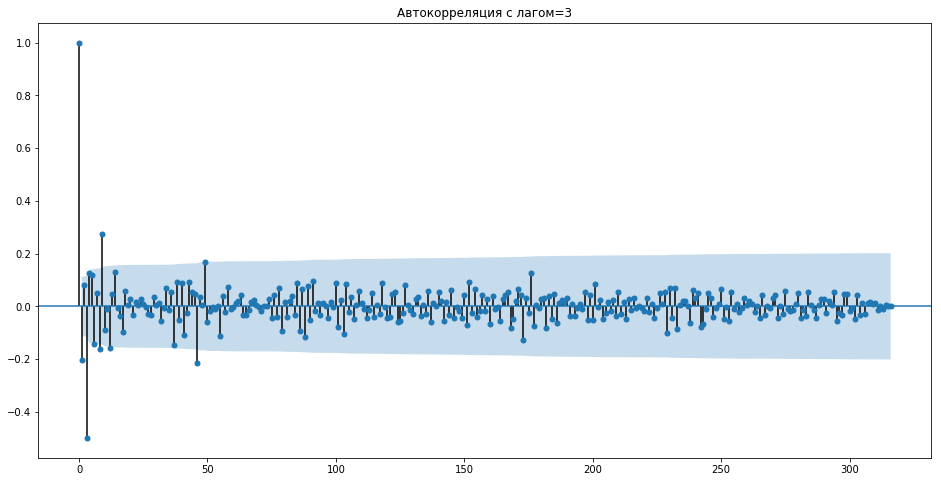

In [384]:
lag = 3
df_lag = df.price.close.pct_change().diff(lag).dropna()
plt.rcParams['figure.figsize'] = [16, 8]
plot_acf(df_lag, title=f"Автокорреляция с лагом={lag}")
plt.show()